In [203]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from patbert.data import utils
mimic_path = "C:\\Users\\fjn197\\PhD\\projects\\PHAIR\\pipelines\\ehr_preprocess\\data\\processed\\mimic-iii-clinical-database-1.4"

## Patients

In [100]:
patients = pd.read_parquet(join(mimic_path,"patients_info.parquet"))
print(patients.GENDER.value_counts())
print(patients.DEATHDATE.notnull().sum(), 'dead patients')
cat_cols = ['INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']
# for col in cat_cols:
    # patients[col] = patients[col].astype('category')

M    26121
F    20399
Name: GENDER, dtype: int64
15759 dead patients


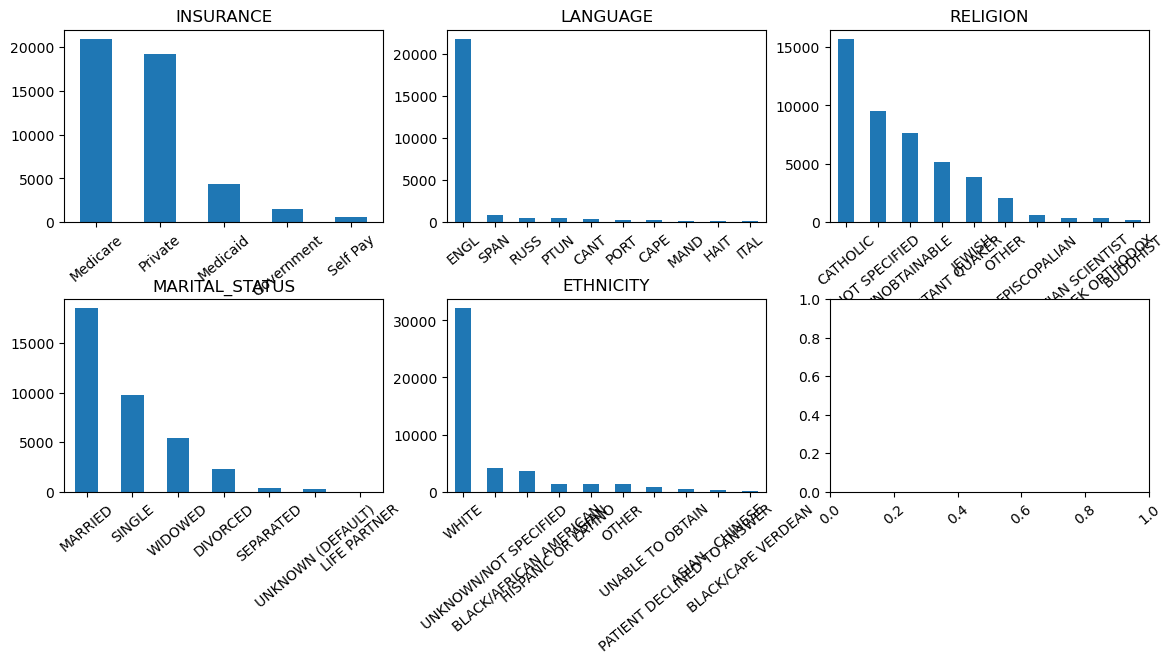

In [107]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))
ax = ax.flatten()
for i, col in enumerate(cat_cols):
    patients[col].value_counts()[:10].plot(kind='bar', ax=ax[i])
    ax[i].set_title(col)
# rotate xtick labels
for a in ax:
    for tick in a.get_xticklabels():
        tick.set_rotation(40)

# increase distance between subplots
fig.subplots_adjust(hspace=0.4)

<AxesSubplot: >

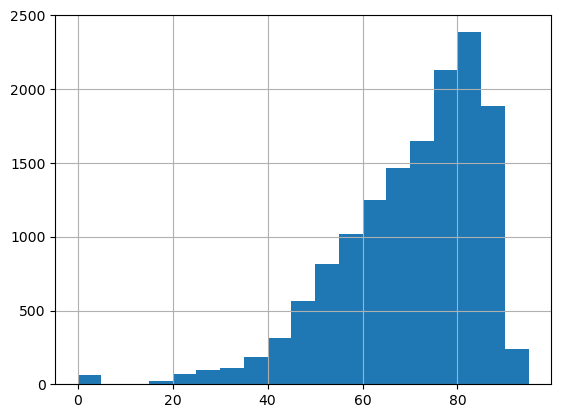

In [124]:
# compute average age of death
patients['death_age'] = patients.DEATHDATE.dt.date - patients.BIRTHDATE.dt.date
death_age = patients[patients.death_age.notnull()]['death_age'].map(lambda x: x.days / 365.25)
death_age.hist(bins=np.arange(0, 100, 5))

## Admissions

In [275]:
transfers = pd.read_parquet(join(mimic_path, "concept.transfer.parquet"))
#transfers["TIMESTAMP"] = transfers["TIMESTAMP"].dt.date
#transfers["TIMESTAMP_END"] = transfers["TIMESTAMP_END"].dt.date

In [276]:
transfers.CONCEPT.value_counts()

TICU          61532
THOSPITAL     58976
TEMERGENCY    30877
Name: CONCEPT, dtype: int64

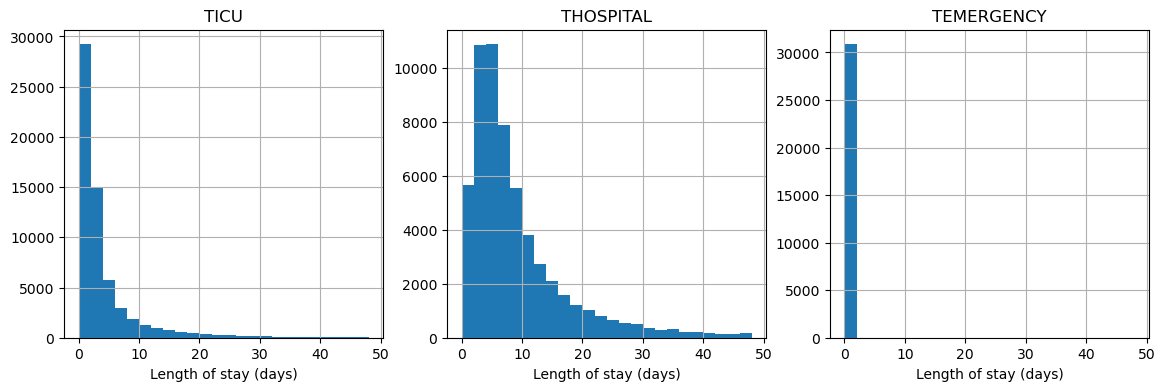

In [277]:
transfers['LOS'] = (transfers.TIMESTAMP_END - transfers.TIMESTAMP).map(lambda x: x.days)
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, col in enumerate(['TICU', 'THOSPITAL','TEMERGENCY']):
    transfers[transfers.CONCEPT==col]['LOS'].hist(ax=ax[i], bins=np.arange(0,50,2))
    ax[i].set_title(col)
    ax[i].set_xlabel('Length of stay (days)')

In [279]:
transfers.DISCHARGE_LOCATION.value_counts()

HOME                         18962
HOME HEALTH CARE             13963
SNF                           7705
REHAB/DISTINCT PART HOSP      6429
DEAD/EXPIRED                  5854
LONG TERM CARE HOSPITAL       2305
SHORT TERM HOSPITAL           1534
DISC-TRAN CANCER/CHLDRN H      669
DISCH-TRAN TO PSYCH HOSP       446
HOSPICE-HOME                   402
LEFT AGAINST MEDICAL ADVI      365
HOSPICE-MEDICAL FACILITY       153
HOME WITH HOME IV PROVIDR       67
OTHER FACILITY                  63
ICF                             47
DISC-TRAN TO FEDERAL HC         11
SNF-MEDICAID ONLY CERTIF         1
Name: DISCHARGE_LOCATION, dtype: int64

In [281]:
transfers.ADMISSION_TYPE.value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

In [278]:
transfers # only events within same stay have a meaningful timeframe

,PID,ADMISSION_ID,TIMESTAMP,TIMESTAMP_END,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,CONCEPT,ICUSTAY_ID,LOS
211,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,THOSPITAL,<NA>,3.0
365,2,163353,2138-07-17 21:20:07,2138-07-17 23:32:21,None,None,None,TICU,243653,0.0
212,3,145834,2101-10-20 17:09:00,2101-10-20 19:24:00,None,None,None,TEMERGENCY,<NA>,0.0
212,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,THOSPITAL,<NA>,10.0
366,3,145834,2101-10-20 19:10:11,2101-10-26 20:43:09,None,None,None,TICU,211552,6.0
...,...,...,...,...,...,...,...,...,...,...
60345,99992,197084,2144-07-25 18:04:42,2144-07-27 17:27:55,None,None,None,TICU,242052,1.0
56565,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,THOSPITAL,<NA>,3.0
60346,99995,137810,2147-02-08 13:53:58,2147-02-10 17:46:30,None,None,None,TICU,229633,2.0
56566,99999,113369,2117-12-30 07:15:00,2118-01-04 16:30:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,SNF,THOSPITAL,<NA>,5.0


TEMERGENCY can be combined with hospital admission, since every emergency admissions is also a hospital admission


In [ ]:
transfers

## Diagnoses

In [164]:
diag = pd.read_parquet(join(mimic_path, "concept.diag.parquet"))
print(len(diag), diag.CONCEPT.nunique())

651047 6985


Text(0.5, 0, 'Number of diagnoses')

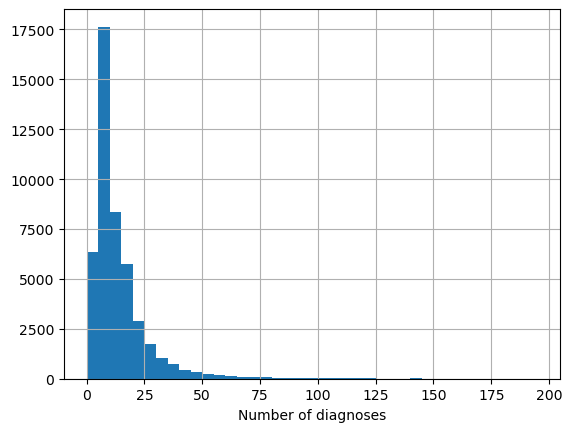

In [142]:
diag.groupby('PID').CONCEPT.count().sort_values( ascending=False).hist(bins=np.arange(0, 200, 5))
plt.xlabel('Number of diagnoses')

Text(0.5, 0, 'Frequency of diagnosis')

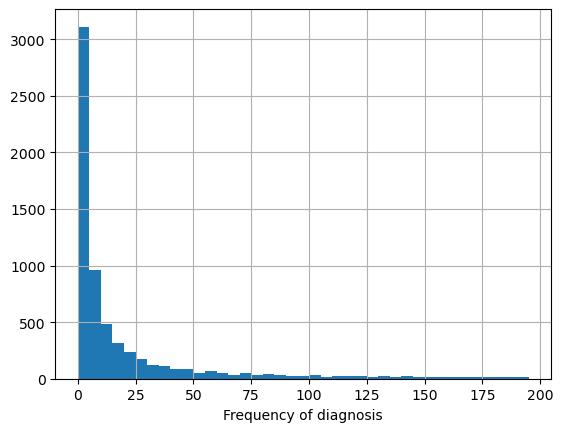

In [145]:
diag.CONCEPT.value_counts().hist(bins=np.arange(0, 200, 5))
plt.xlabel('Frequency of diagnosis')

Text(0.5, 0, 'Frequency of diagnosis')

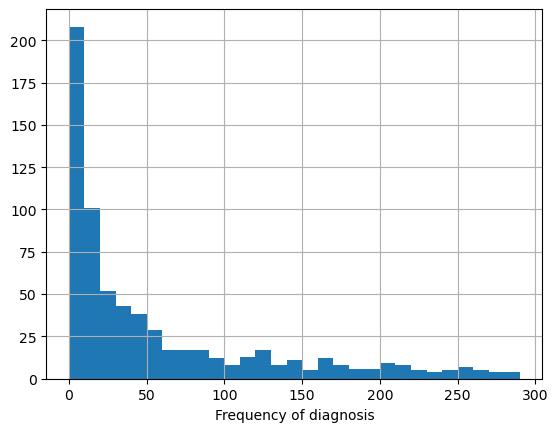

In [152]:
# group diagnosis 
diag['CONCEPT_GROUP'] = diag.CONCEPT.map(lambda x: x[:4])
diag.CONCEPT_GROUP.value_counts().hist(bins=np.arange(0, 300, 10))
plt.xlabel('Frequency of diagnosis')

## Procedures

In [163]:
pro = pd.read_parquet(join(mimic_path, "concept.pro.parquet"))
print(len(pro), pro.CONCEPT.nunique())
pro.head()

240095 2009


,PID,ADMISSION_ID,VALUE,CONCEPT,TIMESTAMP,VALUE_UNIT
95085,2,163353,1,P9955,2138-07-21 15:48:00,SEQ_NUM
45149,3,145834,1,P9604,2101-10-31 13:58:00,SEQ_NUM
45150,3,145834,2,P9962,2101-10-31 13:58:00,SEQ_NUM
45151,3,145834,3,P8964,2101-10-31 13:58:00,SEQ_NUM
45152,3,145834,4,P9672,2101-10-31 13:58:00,SEQ_NUM


Text(0.5, 0, 'Number of procedures')

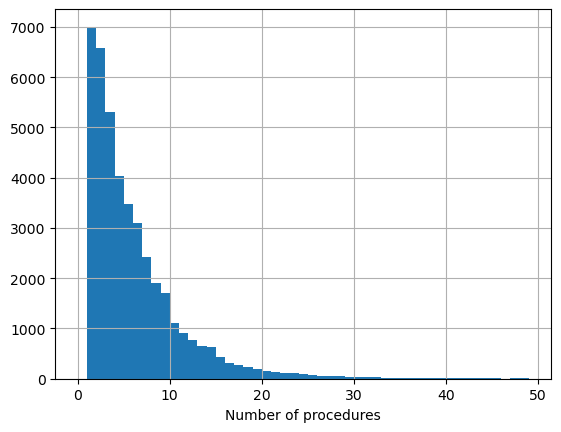

In [162]:
pro.groupby('PID').CONCEPT.count().sort_values( ascending=False).hist(bins=np.arange(0, 50, 1))
plt.xlabel('Number of procedures')

## Medication

In [166]:
med = pd.read_parquet(join(mimic_path, "concept.med.parquet"))
print(len(med), med.CONCEPT.nunique())
med.head()

4156450 4525


,PID,ADMISSION_ID,ICUSTAY_ID,TIMESTAMP,CONCEPT,VALUE,VALUE_UNIT
109,2,163353,243653,2138-07-18,MAmpicillin Sodium,500,mg
107,2,163353,243653,2138-07-18,MNEO*IV*Gentamicin,15.5,mg
110,2,163353,243653,2138-07-18,MSend 500mg Vial,1,VIAL
108,2,163353,243653,2138-07-18,MSyringe (Neonatal) *D5W*,2.4,ml
130,4,185777,294638,2191-03-16,MAcetaminophen,325-650,mg


c:\users\fjn197\phd\projects\phair\pipelines\patbert\patbert\data\utils.py:10: UserWarning: The "similarity" argument is deprecated since dirty_cat 0.3, and will be removed in 0.5.The n-gram similarity is the only one currently supported. 
  enc = SimilarityEncoder()
c:\Users\fjn197\Miniconda3\envs\patbert\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


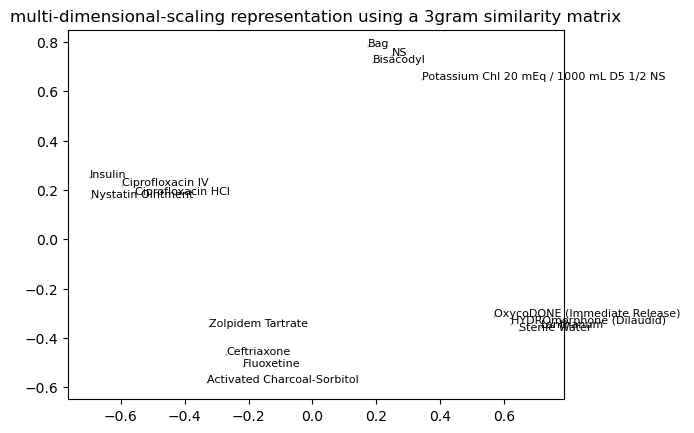

In [230]:
utils.visualize_encoded(med.sample(500), 'CONCEPT', n_points=4, n_neighbors=4)

## Weight

In [266]:
weight = pd.read_parquet(join(mimic_path, "concept.weight.parquet"))
print(len(weight))
weight.head()

3618991


,PID,ADMISSION_ID,ICUSTAY_ID,TIMESTAMP,VALUE,CONCEPT,VALUE_UNIT
0,27063,139787,223259,2133-02-05 06:29:00,83.2,WWEIGHT,kg
1,27063,139787,223259,2133-02-05 05:34:00,83.2,WWEIGHT,kg
2,27063,139787,223259,2133-02-05 05:34:00,83.2,WWEIGHT,kg
3,27063,139787,223259,2133-02-03 12:00:00,83.2,WWEIGHT,kg
4,27063,139787,223259,2133-02-03 12:00:00,83.2,WWEIGHT,kg


Text(0.5, 0, 'Number of unique values per patient')

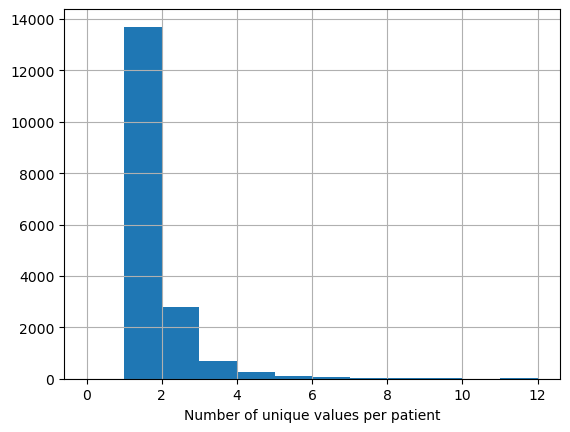

In [267]:
# visualize a hist of unique values per patient
weight.groupby('PID').VALUE.nunique().hist(bins=np.arange(0, 12.5, 1))
plt.xlabel('Number of unique values per patient')

Text(0.5, 0, 'Mean weight (kg)')

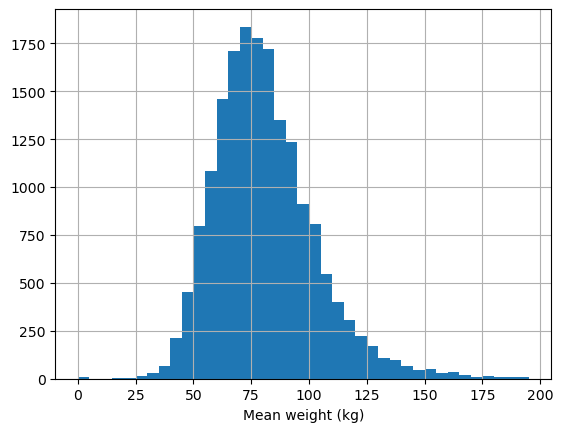

In [268]:
# histogram of mean patient weight
weight.groupby('PID').VALUE.mean().hist(bins=np.arange(0, 200, 5))
plt.xlabel('Mean weight (kg)')

Text(0.5, 0, 'Number of measurements per patient')

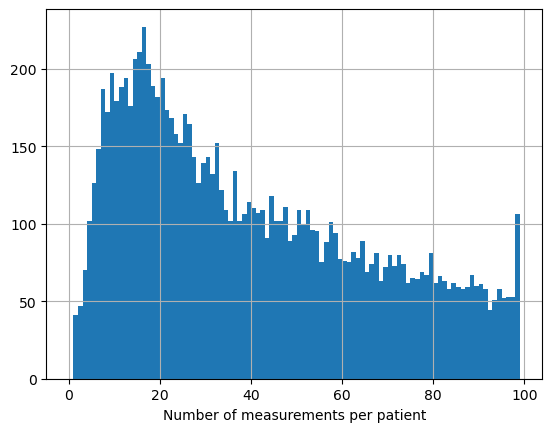

In [269]:
# number of measurements per patient
weight.groupby('PID').VALUE.count().hist(bins=np.arange(0, 100, 1))
plt.xlabel('Number of measurements per patient')

In [270]:
weight['weight_diff'] = weight.groupby('PID').VALUE.diff()
weight

,PID,ADMISSION_ID,ICUSTAY_ID,TIMESTAMP,VALUE,CONCEPT,VALUE_UNIT,weight_diff
0,27063,139787,223259,2133-02-05 06:29:00,83.2,WWEIGHT,kg,NaN
1,27063,139787,223259,2133-02-05 05:34:00,83.2,WWEIGHT,kg,0.0
2,27063,139787,223259,2133-02-05 05:34:00,83.2,WWEIGHT,kg,0.0
3,27063,139787,223259,2133-02-03 12:00:00,83.2,WWEIGHT,kg,0.0
4,27063,139787,223259,2133-02-03 12:00:00,83.2,WWEIGHT,kg,0.0
...,...,...,...,...,...,...,...,...
3618986,90959,136680,240741,2147-08-28 12:00:00,96.0,WWEIGHT,kg,0.0
3618987,90959,136680,240741,2147-08-29 12:16:00,96.0,WWEIGHT,kg,0.0
3618988,90959,136680,240741,2147-08-29 12:16:00,96.0,WWEIGHT,kg,0.0
3618989,90959,136680,240741,2147-08-29 02:30:00,96.0,WWEIGHT,kg,0.0


In [272]:
weight = weight[weight.weight_diff!=0]
# many consecutive measurements are the same

## Labevents

In [165]:
lab = pd.read_parquet(join(mimic_path, "concept.lab.parquet"))
print(len(lab), lab.CONCEPT.nunique())
lab.head()

27854055 691


,PID,ADMISSION_ID,TIMESTAMP,VALUE,VALUE_UNIT,CONCEPT
607,2,163353,2138-07-17 20:48:00,0,%,L26498-6
605,2,163353,2138-07-17 20:48:00,0,%,L28541-1
599,2,163353,2138-07-17 20:48:00,0,%,L4544-3
597,2,163353,2138-07-17 20:48:00,0,%,L704-7
598,2,163353,2138-07-17 20:48:00,0,%,L711-2
